In [15]:
# Bibliotecas
import matplotlib.pyplot as plt
import folium
import numpy as np
from geopy.distance import geodesic
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd

In [16]:
# 1 DADOS DO PROBLEMA DE ERBs
# 1.1 Carrega a geometria do município de Paço do Lamiar - MA
geojson_url = "https://raw.githubusercontent.com/tbrugz/geodata-br/master/geojson/geojs-21-mun.json"
gdf = gpd.read_file(geojson_url)
gdf_municipio = gdf[gdf["name"] == "Paço do Lumiar"].reset_index(drop=True)
geometria_municipio = gdf_municipio.loc[0, "geometry"]

# 1.2 Carrega os Pontos de demanda
pontos_demanda = pd.read_csv("C:/Users/Romul/Documents/Visual_Studio/TCC/pontos_demanda/pontos_demanda.csv")
latmin_pd = pontos_demanda["latitude"].min()
latmax_pd = pontos_demanda["latitude"].max()
lonmin_pd = pontos_demanda["longitude"].min()
lonmax_pd = pontos_demanda["longitude"].max()
pontos_demanda = pontos_demanda.values.tolist()

# 1.3 Gera as ERBs aleatoriamente dentro da geometria do município
def gerar_ERB(n_pontos):
  pontos = []
  while len(pontos) < n_pontos:
    y = np.random.uniform(latmin_pd, latmax_pd)
    x = np.random.uniform(lonmin_pd, lonmax_pd)
    ponto = Point(x, y)
    if geometria_municipio.contains(ponto):
      pontos.append((y, x))
  return pontos

# 1.4 Raio estimado de cobertura de uma ERB 5G
raio = 900   # metros

# 1.5 Qtd de ERBs por indivíduo
erbs_por_individuo = 50

# 1.6 Limita o espaço de busca
def limitar_busca(array):
  latitudes = array[..., 0]
  longitudes = array[..., 1]
  lat_limitada = np.clip(latitudes, latmin_pd, latmax_pd)
  lon_limitada = np.clip(longitudes, lonmin_pd, lonmax_pd)
  array_limitado = np.stack((lat_limitada, lon_limitada), axis=-1)
  return array_limitado

# 1.7 Função objetivo
def funcao_objetivo(populacao, pontos_demanda, raio_metros):
  resultados = []
  m = len(pontos_demanda)

  for individuo in populacao:
    Mi = np.zeros(m)

    for i, ponto in enumerate(pontos_demanda):
      for erb in individuo:
        distancia = geodesic(ponto, erb).meters
        if distancia < raio_metros:
          Mi[i] = 1
          break

    f = (np.sum(Mi) * 100) / m
    resultados.append(f)

  return np.array(resultados)

# 2 INÍCIO DO AlGORITMO PSO
# 2.1 Critérios de parada do loop
max_iteracoes = 300   # Número máximo de iterações
cobertura_max = 100   # Cobertura máxima (100%)

# 2.1 Parâmetros do PSO
tam_pop = 16   # Tamanho da população
cognitivo = 2   # Fator cognitivo
social = 4 - cognitivo    # Fator social

# 2.3 População (Enxame)
populacao = np.array([gerar_ERB(erbs_por_individuo) for _ in range(tam_pop)])
velocidades = np.random.uniform(low=-0.005, high=0.005, size=populacao.shape)
cobertura = np.array(funcao_objetivo(populacao, pontos_demanda, raio))
melhor_cobertura_iteracao = [cobertura.max()]  # Melhor cobertura na iteração atual
cobertura_media_iteracao = [cobertura.mean()]  # Cobertura média do enxame em cada iteração
melhor_cobertura_global = [melhor_cobertura_iteracao[0]]  # Melhor cobertura global até agora
melhor_posicao_global = populacao[cobertura.argmax()]  # Melhor posição global até agora
melhores_posicoes_locais = populacao.copy()  # Melhor posição local de cada partícula
melhores_coberturas_locais = cobertura.copy()  # Melhor cobertura local de cada partícula
posicoes = populacao.copy()

# 2.4 Início das iterações
iteracao = 0
while iteracao < max_iteracoes:
  iteracao += 1

  # 2.4.1 Inércia das partículas
  inercia = (max_iteracoes - iteracao) / max_iteracoes

  # 2.4.2 Números aleatórios para atualização das velocidades
  r1 = np.random.uniform(0, 1, size=populacao.shape)
  r2 = np.random.uniform(0, 1, size=populacao.shape)

  # 2.4.3 Atualiza as velocidades
  velocidades = (
      inercia * velocidades
      + cognitivo * r1 * (melhores_posicoes_locais - posicoes)
      + social * r2 * (melhor_posicao_global[np.newaxis, :, :] - posicoes)
  )

  # 2.4.4 Atualiza as posições das partículas
  posicoes = posicoes + velocidades

  # 2.4.5 Limitar as ERBs à geometria do município
  posicoes = limitar_busca(posicoes)

  # 2.4.6 Avalia a cobertura das novas posições
  cobertura = funcao_objetivo(posicoes, pontos_demanda, raio)

  # 2.4.7 Atualiza a melhor cobertura e posição local
  melhorou = cobertura > melhores_coberturas_locais
  melhores_coberturas_locais[melhorou] = cobertura[melhorou]
  melhores_posicoes_locais[melhorou] = posicoes[melhorou]

  # 2.4.8 Atualiza a melhor cobertura e posição global
  if cobertura.max() > melhor_cobertura_global[-1]:
    melhor_cobertura_global.append(cobertura.max())
    melhor_posicao_global = posicoes[cobertura.argmax()]
  else:
    melhor_cobertura_global.append(melhor_cobertura_global[-1])

  # 2.4.9 Salva os dados para plotagem
  melhor_cobertura_iteracao.append(cobertura.max())
  cobertura_media_iteracao.append(cobertura.mean())

  # 2.4.10 Parada por cobertura máxima
  if cobertura.max() >= cobertura_max:
    break

Iterações: 300
Melhor cobertura global: 84.78 %


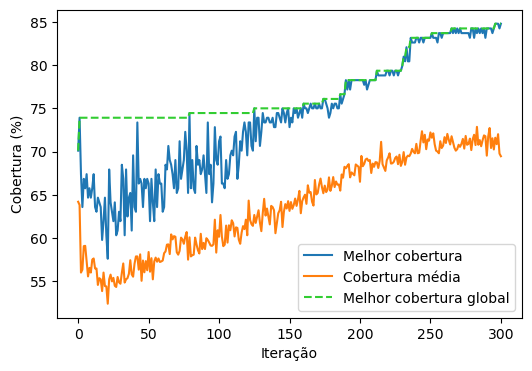

In [17]:
# 2.5 Resultados
# 2.5.1 Valor numérico
print(f"Iterações: {iteracao}")
print(f"Melhor cobertura global: {max(melhor_cobertura_global):.2f} %")

# 2.5.2 Visualização da evolução da cobertura
plt.figure(figsize=(6, 4))
plt.plot(range(max_iteracoes + 1), melhor_cobertura_iteracao, label="Melhor cobertura")
plt.plot(range(max_iteracoes + 1), cobertura_media_iteracao, label="Cobertura média")
plt.plot(range(max_iteracoes + 1), melhor_cobertura_global, label="Melhor cobertura global", linestyle="--", color="LimeGreen")
# plt.title("Evolução da cobertura")
plt.xlabel("Iteração")
plt.ylabel("Cobertura (%)")
plt.legend(loc="lower right")
plt.show()

In [18]:
# 2.5.3 Mapa da melhor cobertura gerada
lon_min, lat_min, lon_max, lat_max = geometria_municipio.bounds
center_lat = (lat_min + lat_max) / 2
center_lon = (lon_min + lon_max) / 2
mapa = folium.Map(location=[center_lat, center_lon], zoom_start=12, width=500, height=350, zoomControl=False)

folium.GeoJson(
    geometria_municipio,
    style_function=lambda x:{
        "fillColor": "blue",
        "color": "blue",
        "weight": 2,
        "fillOpacity": 0.1,
    }
).add_to(mapa)

for ponto in pontos_demanda:
    folium.CircleMarker(
        location=[ponto[0], ponto[1]],
        radius=2,
        color="blue",
        fill=True,
        fill_color="blue",
        fill_opacity=1,
        popup=f"Coordenadas: {ponto[0]}, {ponto[1]}"
    ).add_to(mapa)

for ponto in melhor_posicao_global:
    folium.Circle(
        location=[ponto[0], ponto[1]],
        radius=raio,
        color=None,
        fill=True,
        fill_color="orange",
        fill_opacity=0.7
    ).add_to(mapa)
mapa

In [19]:
# Salva o mapa em HTML
mapa.save("C:/Users/Romul/Documents/Visual_Studio/TCC/PSO/mapa_cobertura.html")